# Concise Models: Tutorial
Created by Christoffer Rubensson on the 2025-11-29.

This notebook shows how to create and evaluate concise process models using our python package. 

### Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
# App directory
project_root = Path.cwd().parent  # Adjust this if necessary
sys.path.append(str(project_root))

**Import packages**

*For import without pip*
> Note: We will soon add the option to download the package via pip.

In [3]:
import pandas as pd
import pm4py
from src.variant_extraction.utils.data_importing import load_event_log
#from src.variant_extraction.utils.data_processing import group_unique_values_to_dict
from src.variant_extraction.cm_methods.cm_orchestrator import enhance_log_for_concise_model, discover_concise_model
from src.variant_extraction.cm_methods.visualization.concisemodelbuilder import build_concise_dfg
from src.variant_extraction.cm_methods.evaluation.evaluation import generate_evaluation_statistics_df

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'graph_tool'}


Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}


In [4]:
log = load_event_log("runningexample.xes", "input") # change log name and add the log as an .xes file in the "data/input folder"
log_name="log"
df = log.copy()

/Users/christofferrubensson/Documents/GITHUB/VARIANT_EXTRACTION/data/input/runningexample.xes


parsing log, completed traces :: 100%|██████████| 6/6 [00:00<00:00, 2268.42it/s]


**Define columns**

In [5]:
ACT_COL = "concept:name"
CASE_COL = "case:concept:name"
TIME_COL = "time:timestamp"
RES_COL = "org:resource"
RTIME_COL = "time:relative:seconds"
NRTIMECASE_COL = "time:relative:normalized:case"
NRTIMELOG_COL = "time:relative:normalized:log"
STAGE_COL = "stage:number"
COMM_COL = 'community:number'
MULTI_ACT_COL = "concept:name:multiact"
MULTI_COMM_COL = "concept:name:communities"

### Enhance log

**Enhance log**

Adapt the following parameters to change the size and complexity of the resulting model.

In [6]:
# define dependency threshold
dependency_threshold=0.5

# define number of stages
num_stages = 2

# define number of representative communities (0 returns all, 1 returns 2 nodes)
num_comm_ranks=0

# define number of representative activites (0 returns all, 1 returns 1)
num_act_ranks=0

# decide if you also want to hide the most common activities
hide_common_activities=False

In [7]:
df_comm = enhance_log_for_concise_model(
        df,
        ACT_COL = ACT_COL,
        CASE_COL = CASE_COL,
        TIME_COL = TIME_COL,
        RES_COL = RES_COL,
        RTIME_COL = RTIME_COL,
        NRTIMECASE_COL = NRTIMECASE_COL,
        NRTIMELOG_COL = NRTIMELOG_COL,
        STAGE_COL = STAGE_COL,
        COMM_COL = COMM_COL,
        MULTI_ACT_COL = MULTI_ACT_COL,
        MULTI_COMM_COL = MULTI_COMM_COL,
        num_stages = num_stages, 
        dependency_threshold=dependency_threshold, # thresh
        num_comm_ranks=num_comm_ranks, # communities 
        num_act_ranks=num_act_ranks, # activities
        hide_common_activities=hide_common_activities # hide common activities
        )

Message: No transition-activity were be created. No transition column.


In [8]:
df_comm.head(2)

,case:concept:name,concept:name,time:timestamp,time:timestamp:casestart,time:timestamp:relative,time:relative:seconds,time:relative:seconds:log,time:relative:normalized:log,time:relative:normalized:case,order:position,...,stage:number,community:number,community_rank_overall,community_rank_within,activity_rank_overall,activity_rank_within,common_activities,concept:name:rep,concept:name:multiact,concept:name:communities
14,1,register request,2010-12-30 11:02:00+00:00,2010-12-30 11:02:00+00:00,0 days 00:00:00,0,0.00000,0.000000,0.000000,0,...,0,1,0,0,0,0,1,register request,register request,0
15,1,examine thoroughly,2010-12-31 10:06:00+00:00,2010-12-30 11:02:00+00:00,0 days 23:04:00,83040,11.32709,0.052676,0.118069,0,...,0,2,2,2,5,0,1,examine thoroughly,examine thoroughly,2


### Model Discovery and Visualization

**Discover model**

We discover: 
- a DFG as tuples of edges (`dfg`), 
- the start activites (`s`), 
- the end activites (`e`), 
- a dictionary of community-activity connections (`comm_acts_dict`) and 
- a dictionary of stage-community connections (`stage_comm_dict`).

In [9]:
# discover DFG
#dfg_comm1, s_comm1, e_comm1 = pm4py.discover_dfg(df_comm, activity_key=MULTI_COMM_COL)
# discover stage-community connections
#stage_comm_dict1 = group_unique_values_to_dict(
#    df_comm, key_col=STAGE_COL, item_col=MULTI_COMM_COL, order_by="community_rank_within")
# discover community-activity connections
#comm_acts_dict1 = group_unique_values_to_dict(
#    df_comm, key_col=MULTI_COMM_COL, item_col=MULTI_ACT_COL)

In [10]:
dfg_comm, s_comm, e_comm, stage_comm_dict, comm_acts_dict = discover_concise_model(
    df_comm,
    STAGE_COL = STAGE_COL,
    MULTI_ACT_COL = MULTI_ACT_COL,
    MULTI_COMM_COL = MULTI_COMM_COL)

**Visualize model**

In [11]:
# choose to hide non-representative activites in the graph
hide_hidden_activities = False

In [12]:
dot_res = build_concise_dfg(
        dfg_comm, 
        s_comm, 
        e_comm,
        comm_acts_dict,
        stage_comm_dict,
        hide_hidden_activities=hide_hidden_activities)

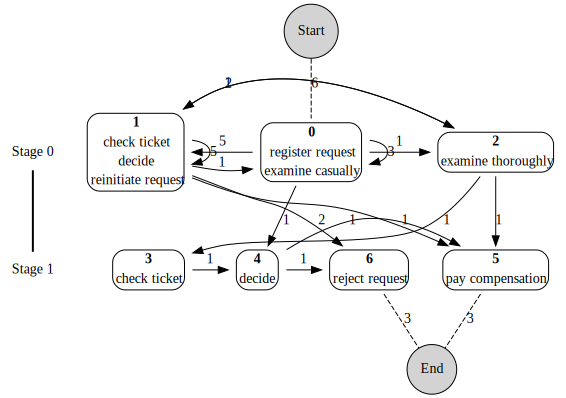

In [13]:
dot_res

### Evaluate Log and Model

Here, we generate a dataframe with evaluation statistics for the log defined above.

In [14]:
eva = generate_evaluation_statistics_df(
        df_comm, 
        dfg_comm,
        ACT_COL = ACT_COL,
        CASE_COL = CASE_COL,
        STAGE_COL = STAGE_COL,
        COMM_RANK_OVERALL_COL='community_rank_overall',
        MULTI_ACT_COL = MULTI_ACT_COL,
        log_name = log_name,
        log_name_col="log_name")

In [15]:
combined = pd.concat([eva], ignore_index=True)
combined

,log_name,num_cases,num_events,num_activities,num_comtactivities,num_stages,num_communities,num_nodes,num_edges,num_cycles,num_selfloops,sum_selfloops_weight
0,log,6,33,8,8,2,7,7,15,5,2,8
